### Load Packages

In [1]:
# Reading in, manipulations
import pandas as pd
import numpy as np
import re

# Plotting
import plotly.express as px
import plotly.io as pio
import plotly.figure_factory as ff

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Evaluating the model
from sklearn.metrics import classification_report, confusion_matrix

#### Set a theme

In [16]:
pio.templates.default = "plotly_white"
pio.renderers.default = 'svg'

### Read data and manipulate it

In [3]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

Convert from CamelCase to snake

In [4]:
def to_snake(camel_case_str):
    return ''.join(['_' + i.lower() if i.isupper() else i for i in camel_case_str]).lstrip('_')
df_train.columns = [to_snake(camel_str) for camel_str in df_train.columns]
df_test.columns = [to_snake(camel_str) for camel_str in df_test.columns]

#### Add names
The data is manually inputted and probably not validated, therefore I'm  
applying some changes and adding new variables:

1. Dates and times
2. Age in days and age in years
3. Sex (M, F, unknown)
4. Reproduction 
5. Simplify color names
6. Has Name (no name versus named)
7. Mix (is mix versus not a mix)
8. Age Category (newborn, baby, animal)
8. Is aggressive breed

Add dates and time measures

In [5]:
df_train['date_time'] = pd.to_datetime(df_train['date_time'])
df_train['date'] = df_train['date_time'].dt.date
df_train['hour'] = df_train['date_time'].dt.hour

Add months

In [6]:
df_train['month'] = df_train['date_time'].dt.month
df_train['year_month'] = df_train['date_time'].dt.strftime("%Y/%m")

Convert the age of pets in days

In [7]:
def convert_to_days(age_str):
    if pd.isna(age_str):
        return None
    match = re.match(r'(\d+)\s*(year|month|week|day)s?', str(age_str))
    if match:
        value, unit = match.groups()
        value = int(value)
        if unit == 'year':
            return value * 365
        elif unit == 'month':
            return value * 30
        elif unit == 'week':
            return value * 7
        elif unit == 'day':
            return value
    return None 

df_train['age_in_days'] = df_train['ageupon_outcome'].apply(convert_to_days)
df_train['age_in_years'] = df_train['age_in_days'] / 365

df_test['age_in_days'] = df_test['ageupon_outcome'].apply(convert_to_days)
df_test['age_in_years'] = df_test['age_in_days'] / 365

Extract sex

In [8]:
df_train['sex'] = df_train['sexupon_outcome'].str.split().str[-1]
df_train['reproduction'] = df_train['sexupon_outcome'].str.split().str[0].fillna('Unknown')

df_test['sex'] = df_test['sexupon_outcome'].str.split().str[-1]
df_test['reproduction'] = df_test['sexupon_outcome'].str.split().str[0].fillna('Unknown')

Simplify color

In [9]:
df_train['simple_color'] = df_train['color'].apply(lambda x: x.split('/')[0])
df_test['simple_color'] = df_test['color'].apply(lambda x: x.split('/')[0])

Extract mix from breed

In [10]:
df_train['is_mix'] = df_train['breed'].str.contains('mix', case = False, na = False)
df_test['is_mix'] = df_test['breed'].str.contains('mix', case = False, na = False)

Add name flag

In [11]:
df_train['has_name'] = df_train.name.notna()
df_test['has_name'] = df_test.name.notna()

And finally, let's see how many babies and adult animals we have.  
This is a bit hard to derive, as this differes by animal and by breed. Also it's a process not an outcome.  

Will make it simple for this analysis and have 3 categories:
- newborn (8 weeks)
- baby (up to 1 year)
- adults (from 1 year or more)

In [12]:
newborn_max_age = 8 * 7  
baby_max_age = 365       

df_train['age_category'] = pd.cut(df_train['age_in_days'], bins = [0, newborn_max_age, baby_max_age, float('inf')],
                                  labels = ['newborn', 'baby', 'adult'], right = False)
df_test['age_category'] = pd.cut(df_test['age_in_days'], bins = [0, newborn_max_age, baby_max_age, float('inf')],
                                  labels = ['newborn', 'baby', 'adult'], right = False)

Now, let's analyze!

In [13]:
df_train['outcome_type'].value_counts()

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: outcome_type, dtype: int64

* The highest share were adopted and transfered.
* A few animals died, which is a less likely scenario. Predicting such cases is almost impossible.

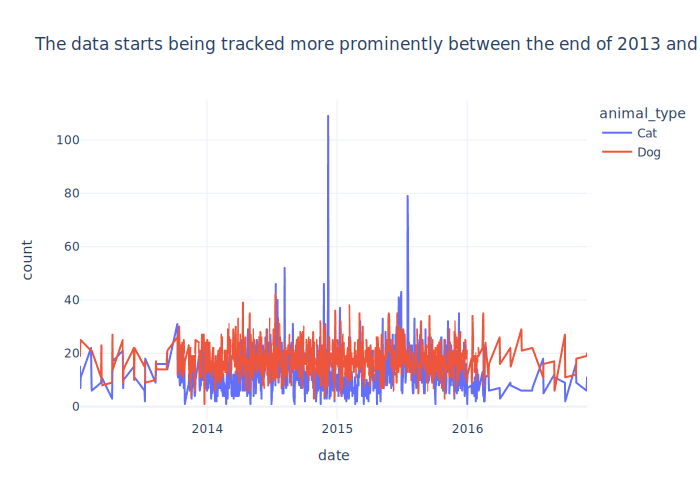

In [17]:
df_animals_date = df_train.groupby(['date', 'animal_type']).size().reset_index(name = 'count')
fig = px.line(df_animals_date, x = 'date', y = 'count', color = 'animal_type', title = 'The data starts being tracked more prominently between the end of 2013 and the end of 2015.')
fig.show(engine = 'kaleido')

* The data seems to be more tracked from end of 2013 until end of 2015.
* The animal shelter gets both cats and dogs, and more likely to shelter dogs. 
* Interestingly, there were some peaks, would have to investigate that later.

In [32]:
df_outcome_cnt = df_train.groupby(['outcome_type', 'animal_type']).size().reset_index(name = 'count')
df_outcome_cnt['proportion'] = df_outcome_cnt.groupby('animal_type')['count'].transform(lambda x: x / x.sum() * 100)
px.bar(df_outcome_cnt, x = 'animal_type', y = 'proportion', color = 'outcome_type', title = 'Dogs are more likely to be returned to the owner and cats to be transferred.')

Let's check what could be the reason for that.

In [33]:
px.box(df_train, x = 'animal_type', y = 'age_in_years', log_y = True, title = 'Most sheltered animals are young, especially the cats.') 

In [36]:
df_animals_date = df_train.groupby(['year_month', 'animal_type', 'age_category']).size().reset_index(name = 'count')
px.line(df_animals_date, x = 'year_month', y = 'count', color = 'age_category', facet_row = 'animal_type', title = 'Quite some peaks! Are these due to transfers?')

Also ...
* Most cats are newborns or babies.
* Most dogs that end up in shelters are already adults.

In [37]:
df_animal_name = df_train.groupby(['animal_type', 'has_name', 'outcome_type']).size().reset_index(name = 'count')
px.bar(df_animal_name, x = 'has_name', y = 'count', color = 'outcome_type', facet_col = 'animal_type', title = 'Having a name leads to better outcomes.')

* More than 50% of the cats have no name, whereas dogs are less likely to not have one.
* Dogs with names are more likely to be returned to their owner.
* Cats with names are more likely to be adopted. There must be something more to that...

In [41]:
px.box(df_train, x = 'has_name', y = 'age_in_years', facet_col = 'animal_type', title = 'They are also a bit older when having a name.')

In [43]:
px.box(df_train, x = 'outcome_type', y = 'age_in_years', title = 'When it comes to pets returned to owners, they are more likely already adults.')

* Most adopted pets are young, a huge part being babies. 
* The adult portion comes more from the dogs side.

In [44]:
df_repr_outcome = df_train.groupby(['animal_type', 'reproduction', 'outcome_type']).size().reset_index(name = 'count')
df_repr_outcome['proportion'] = df_repr_outcome.groupby(['reproduction', 'animal_type'])['count'].transform(lambda x: x / x.sum() * 100)
px.bar(df_repr_outcome, x = 'reproduction', y = 'proportion', color = 'outcome_type', facet_row = 'animal_type', title = 'Neutered and spayed pets are more likely to be adopted!')

* It would be a consideration to neuter/spay pets to increase their likelihood of being adopted.
* Intact are less likely to be adopted.

In [46]:
px.histogram(df_train, x = 'hour', facet_row = 'outcome_type', facet_col = 'animal_type', height = 1000, width = 800, title = 'Adoption is more likely to happen in the late hours, whereas transfers in the earlier.')

* Transfers are probably pre-planned and have a clear schedule.
* Most people work during the day, so probably they would adopt after work with a clear mind.

### Modeling with Random Forest

1. Filling NAs

In [ ]:
px.histogram(df_train, x = 'age_in_years')

Will use the median for imputation.

In [102]:
df_train['age_in_years'].fillna(df_train['age_in_years'].median(), inplace = True)

2. Finally, one-hot encoding ...

In [103]:
df_dummies = pd.get_dummies(df_train[['sex', 'reproduction', 'simple_color', 'animal_type', 'age_category', 'breed']], drop_first = True)
df_train = pd.concat([df_dummies, df_train], axis = 1)

df_dummies_test = pd.get_dummies(df_test[['sex', 'reproduction', 'simple_color', 'animal_type', 'age_category', 'breed']], drop_first = True)
df_test = pd.concat([df_dummies_test, df_test], axis = 1)

In [106]:
X = df_train.drop(columns = ['animal_id', 'outcome_type', 'outcome_subtype', 'animal_type', 
                             'sexupon_outcome', 'ageupon_outcome', 'simple_color', 'breed', 'color', 
                              'hour','date_time', 'date', 'month', 'year_month', 'age_in_days', 
                             'sex', 'reproduction', 'age_category', 'name', 'animal_type_Dog']).values.reshape(-1, 1445)
y = df_train['outcome_type']
X_test = df_test.drop(columns = ['animal_type', 'sexupon_outcome', 'ageupon_outcome', 'simple_color', 'breed', 'color', 
                             'date_time', 'age_in_days','sex', 'reproduction', 'age_category', 'name', 'animal_type_Dog']).values.reshape(-1, 974)

KeyError: "['animal_id', 'outcome_type', 'outcome_subtype', 'hour', 'date', 'month', 'year_month', 'age_category', 'animal_type_Dog'] not found in axis"

In [121]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size =  0.2, stratify = y, random_state = 42)

In [82]:
X_train.shape, y_train.shape

((21383, 1445), (21383,))

Modeling in Random Forest ...

In [122]:
model = RandomForestClassifier(random_state = 42)
model.fit(X_train, y_train)
print("Training Accuracy:", model.score(X_train, y_train))

Training Accuracy: 0.8513772623111818


Validate model

In [123]:
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))

                 precision    recall  f1-score   support

       Adoption       0.64      0.76      0.69      2154
           Died       0.00      0.00      0.00        39
     Euthanasia       0.32      0.12      0.18       311
Return_to_owner       0.42      0.39      0.41       957
       Transfer       0.66      0.62      0.64      1885

       accuracy                           0.60      5346
      macro avg       0.41      0.38      0.38      5346
   weighted avg       0.58      0.60      0.59      5346



In [124]:
unique_labels = sorted(y_val.unique())

cm = confusion_matrix(y_val, y_pred, labels = unique_labels)

fig = ff.create_annotated_heatmap(z = cm,
                                  x = unique_labels,
                                  y = unique_labels,
                                  hovertemplate='Count: %{z}',
                                  colorscale='Viridis')
fig.update_layout(xaxis = dict(title = 'Predicted Label'), yaxis = dict(title = 'Actual Label'))
fig.show()

* Tranfers and Return to Owner are mistaken as Adoption and vice versa.
* Euthanasia are mistaked as transfers.
* Death is not something we could predict.

Let's make things more simple for us.  
At the end of the day we want the pets to find someone to take care of them.

Let's put the outcomes into smaller groups:
1) Owner Found = Return to Owner and Adoption
2) Owner in Search = Transfer
3) Owner not Found = Euthanasia and Death

In [125]:
outcome_to_group = {
    'Return_to_owner': 'Owner Found',
    'Adoption': 'Owner Found',
    'Transfer': 'Owner in Search',
    'Euthanasia': 'Owner not Found',
    'Died': 'Owner not Found'
}

# Map outcomes to groups
df_train['outcome'] = df_train['outcome_type'].map(outcome_to_group)

In [126]:
y = df_train['outcome']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size =  0.2, stratify = y, random_state = 42)

In [127]:
model.fit(X_train, y_train)
print("Training Accuracy:", model.score(X_train, y_train))

0.8954309498199504

In [128]:
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))

                 precision    recall  f1-score   support

    Owner Found       0.77      0.89      0.82      3111
Owner in Search       0.70      0.59      0.64      1885
Owner not Found       0.35      0.15      0.21       350

       accuracy                           0.74      5346
      macro avg       0.61      0.54      0.56      5346
   weighted avg       0.72      0.74      0.72      5346



In [129]:
unique_labels = sorted(y_val.unique())

cm = confusion_matrix(y_val, y_pred, labels = unique_labels)

fig = ff.create_annotated_heatmap(z = cm,
                                  x = unique_labels,
                                  y = unique_labels,
                                  hovertemplate='Count: %{z}',
                                  colorscale='Viridis')
fig.update_layout(xaxis = dict(title = 'Predicted Label'), yaxis = dict(title = 'Actual Label'))
fig.show()